<a href="https://colab.research.google.com/github/mendoanjoe/sentiment-analysis/blob/main/Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [3]:
!pip install Sastrawi
!pip install textblob
!pip install transformers

In [4]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import re
import nltk
import pickle
import numpy as np

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google.colab import drive
from google.colab import files
from wordcloud import WordCloud
from textblob import TextBlob
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data sociolla & female daily

## Upload raw data
* data must sociolla.json and femaledaily.json

In [5]:
data_files = files.upload()

Saving femaledaily.json to femaledaily.json
Saving sociolla.json to sociolla.json


reading data from json file

In [7]:
json_sociolla = json.loads(data_files['sociolla.json'])
json_femaleDaily = json.loads(data_files['femaledaily.json'])

## Normalize json to data frame

Following instruction from https://towardsdatascience.com/how-to-convert-json-into-a-pandas-dataframe-100b2ae1e0d8

In [8]:
df_sociolla = pd.json_normalize(json_sociolla, meta=[['user', 'name'], ['product', 'name']])
df_femaleDaily = pd.json_normalize(json_femaleDaily, meta=[['product', 'packaging_avg'], ['product', 'rating_avg'], ['product', 'total_review'], ['user', 'age_range']])

## Preview raw data frame

Sociolla raw data:

In [9]:
df_sociolla.head()

,_id,details,star_texture,star_effectiveness,star_packaging,star_value_for_money,average_rating,created_at,detail,user.name,product.name
0,61b8df2fc6f4e3442ee516fa,"suka banget sama produk ini, gampang dibawa ke...",5,5,5,5,5.0,2021-12-14T18:15:11.866Z,"suka banget sama produk ini, gampang dibawa ke...",Zahra Asyifa,Cica Beat The Sun Powder
1,61b8a6cd8b24ecb6db2e6736,ini aku pertama kali beli produk ini dan aku e...,5,5,5,5,5.0,2021-12-14T14:14:37.221Z,ini aku pertama kali beli produk ini dan aku e...,Nurlela Achmad,Cica Beat The Sun SPF 50 PA ++++
2,61b89df3b7db5e79311918c7,"I love the packaging, the texture, tapi kurang...",4,4,5,5,4.5,2021-12-14T13:36:51.246Z,"I love the packaging, the texture, tapi kurang...",adinda subagio,Cica Beat The Sun SPF 50 PA ++++
3,61b86abe0ba0d9449dae81f1,menyesal kenapa baru tahu ada sunscreen yang b...,5,5,5,5,5.0,2021-12-14T09:58:22.157Z,menyesal kenapa baru tahu ada sunscreen yang b...,Amalia Anggraini,Cica Beat The Sun Powder
4,61b8692ca4eb722150610da8,suka!! bagus bgt buat touch up ditambah lg ini...,5,5,5,4,4.8,2021-12-14T09:51:40.672Z,suka!! bagus bgt buat touch up ditambah lg ini...,Winda Teresia,Cica Beat The Sun Powder


Female daily raw data:

In [10]:
df_femaleDaily.head()

,rvwr_review_rating,rvwr_review_txt,fullname,review_cur_ori,review_cur_update,prod_item,brand_name,_id.$oid,product.total_review,product.packaging_avg,product.rating_avg,user.age_range
0,5,akhirnya beli produk ini pas banget lagi sale ...,Nadira Ananda Thamrin,IDR,IDR,Cica Beat The Sun Powder,N'pure,619a26b06f6dfb81c79927e2,1452,1,4.9,19 - 24
1,5,"Sun powder dari N'pure ini bagus bangett, gabo...",Oktavia Zuhrotul Hafshah,IDR,IDR,Cica Beat The Sun Powder,N'pure,619a26b06f6dfb81c7992804,1452,1,4.9,18 and Under
2,5,waw sumpah si ini sunscreen yang bener bener b...,wawa,IDR,IDR,Cica Beat The Sun,N'pure,619a26b06f6dfb81c7992833,2952,1,4.9,18 and Under
3,5,N'PURE Cica Beat The Sun Powder ini bener-bene...,Shinta Dwi Asmarani,IDR,IDR,Cica Beat The Sun Powder,N'pure,619a26b06f6dfb81c7992844,1452,1,4.9,25 - 29
4,5,Suka sama teksturnya powder dan aplikatornya b...,Selizar Effendy,IDR,IDR,Cica Beat The Sun Powder,N'pure,619a26b06f6dfb81c79928a8,1452,1,4.9,25 - 29


## Picking data source and rename column

In [11]:
data_sociolla = df_sociolla[['details']]
data_femaleDaily = df_femaleDaily[['rvwr_review_txt']]

# rename to details
data_femaleDaily.rename(columns = {'rvwr_review_txt':'details'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Preview each data source

Sociolla data source:

In [12]:
data_sociolla.head()

,details
0,"suka banget sama produk ini, gampang dibawa ke..."
1,ini aku pertama kali beli produk ini dan aku e...
2,"I love the packaging, the texture, tapi kurang..."
3,menyesal kenapa baru tahu ada sunscreen yang b...
4,suka!! bagus bgt buat touch up ditambah lg ini...


Female daily data source:

In [13]:
data_femaleDaily.head()

,details
0,akhirnya beli produk ini pas banget lagi sale ...
1,"Sun powder dari N'pure ini bagus bangett, gabo..."
2,waw sumpah si ini sunscreen yang bener bener b...
3,N'PURE Cica Beat The Sun Powder ini bener-bene...
4,Suka sama teksturnya powder dan aplikatornya b...


## Join two data into one dataframe

In [14]:
data_sociolla['source'] = 'sociolla'
data_femaleDaily['source'] = 'femaleDaily'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
data = data_sociolla.append(data_femaleDaily)
data.reset_index(inplace=True)

In [16]:
data.head()

,index,details,source
0,0,"suka banget sama produk ini, gampang dibawa ke...",sociolla
1,1,ini aku pertama kali beli produk ini dan aku e...,sociolla
2,2,"I love the packaging, the texture, tapi kurang...",sociolla
3,3,menyesal kenapa baru tahu ada sunscreen yang b...,sociolla
4,4,suka!! bagus bgt buat touch up ditambah lg ini...,sociolla


# Text Preprocessing

## Case folding / to lower case

In [17]:
def preUsingCaseFolding(text):
  return text.casefold()

In [18]:
data['Pre #1'] = data['details'].apply(preUsingCaseFolding)

Pre #1 data:

In [19]:
data.head()

,index,details,source,Pre #1
0,0,"suka banget sama produk ini, gampang dibawa ke...",sociolla,"suka banget sama produk ini, gampang dibawa ke..."
1,1,ini aku pertama kali beli produk ini dan aku e...,sociolla,ini aku pertama kali beli produk ini dan aku e...
2,2,"I love the packaging, the texture, tapi kurang...",sociolla,"i love the packaging, the texture, tapi kurang..."
3,3,menyesal kenapa baru tahu ada sunscreen yang b...,sociolla,menyesal kenapa baru tahu ada sunscreen yang b...
4,4,suka!! bagus bgt buat touch up ditambah lg ini...,sociolla,suka!! bagus bgt buat touch up ditambah lg ini...


## Punctuation removal

In [20]:
def preUsingPunctuationRemoval(text):
  return text.translate(str.maketrans('', '', string.punctuation))

In [21]:
data['Pre #2'] = data['Pre #1'].apply(preUsingPunctuationRemoval)

Pre #2 data:

In [22]:
data.head()

,index,details,source,Pre #1,Pre #2
0,0,"suka banget sama produk ini, gampang dibawa ke...",sociolla,"suka banget sama produk ini, gampang dibawa ke...",suka banget sama produk ini gampang dibawa kem...
1,1,ini aku pertama kali beli produk ini dan aku e...,sociolla,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...
2,2,"I love the packaging, the texture, tapi kurang...",sociolla,"i love the packaging, the texture, tapi kurang...",i love the packaging the texture tapi kurang s...
3,3,menyesal kenapa baru tahu ada sunscreen yang b...,sociolla,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...
4,4,suka!! bagus bgt buat touch up ditambah lg ini...,sociolla,suka!! bagus bgt buat touch up ditambah lg ini...,suka bagus bgt buat touch up ditambah lg ini a...


## Remove emoji & emoticon

In [23]:
# Upload dictionary emoticon 'Emoticon_Dict.p'
data_file_emoticon = files.upload()

Saving Emoticon_Dict.p to Emoticon_Dict.p


In [24]:
with open('/content/Emoticon_Dict.p', 'rb') as fp:
  Emoticon_Dict = pickle.load(fp)

In [25]:
def preUsingRemoveEmoji(text):
  em_pattern = re.compile("["
  u"\U0001F600-\U0001F64F" # emoticons
  u"\U0001F300-\U0001F5FF" # symbols & pictographs
  u"\U0001F680-\U0001F6FF" # transport & map symbols
  u"\U0001F1E0-\U0001F1FF" # flags (iOS)
  u"\U00002702-\U000027B0"
  u"\U000024C2-\U0001F251"
  "]+", flags=re.UNICODE)
  return em_pattern.sub(r'', text)

def preUsingRemoveEmoticon(text):
  emt_pattern = re.compile(u'(' + u'|'.join(k for k in Emoticon_Dict) + u')')
  return emt_pattern.sub(r'', text)

In [26]:
data['Pre #3'] = data['Pre #2'].apply(preUsingRemoveEmoji)
data['Pre #3'] = data['Pre #3'].apply(preUsingRemoveEmoticon)

Pre #3 data:

In [27]:
data.head()

,index,details,source,Pre #1,Pre #2,Pre #3
0,0,"suka banget sama produk ini, gampang dibawa ke...",sociolla,"suka banget sama produk ini, gampang dibawa ke...",suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang dibawa kem...
1,1,ini aku pertama kali beli produk ini dan aku e...,sociolla,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...
2,2,"I love the packaging, the texture, tapi kurang...",sociolla,"i love the packaging, the texture, tapi kurang...",i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...
3,3,menyesal kenapa baru tahu ada sunscreen yang b...,sociolla,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...
4,4,suka!! bagus bgt buat touch up ditambah lg ini...,sociolla,suka!! bagus bgt buat touch up ditambah lg ini...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up ditambah lg ini a...


## Regex cleaning

In [28]:
def cleanUsingRegex(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
  text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
  text = re.sub(r"http\S+", '', text) # remove link
  text = text.replace('\n', ' ') # replace new line into space
  text = text.strip(' ') # remove characters space from both left and right text
  
  return text

In [29]:
data['Pre #4'] = data['Pre #3'].apply(cleanUsingRegex)

Pre #4 data:

In [30]:
data.head()

,index,details,source,Pre #1,Pre #2,Pre #3,Pre #4
0,0,"suka banget sama produk ini, gampang dibawa ke...",sociolla,"suka banget sama produk ini, gampang dibawa ke...",suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang dibawa kem...
1,1,ini aku pertama kali beli produk ini dan aku e...,sociolla,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...
2,2,"I love the packaging, the texture, tapi kurang...",sociolla,"i love the packaging, the texture, tapi kurang...",i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...
3,3,menyesal kenapa baru tahu ada sunscreen yang b...,sociolla,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...
4,4,suka!! bagus bgt buat touch up ditambah lg ini...,sociolla,suka!! bagus bgt buat touch up ditambah lg ini...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up ditambah lg ini a...


## Using Sastrawi to reduce inflected words in Indonesian Language

In [31]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [32]:
def cleanUsingSastrawi(text):
  return stemmer.stem(text)

In [33]:
data['Pre #5'] = data['Pre #4'].apply(cleanUsingSastrawi)

Pre #5 data:

In [34]:
data.head()

,index,details,source,Pre #1,Pre #2,Pre #3,Pre #4,Pre #5
0,0,"suka banget sama produk ini, gampang dibawa ke...",sociolla,"suka banget sama produk ini, gampang dibawa ke...",suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang bawa mana ...
1,1,ini aku pertama kali beli produk ini dan aku e...,sociolla,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...
2,2,"I love the packaging, the texture, tapi kurang...",sociolla,"i love the packaging, the texture, tapi kurang...",i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...
3,3,menyesal kenapa baru tahu ada sunscreen yang b...,sociolla,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,sesal kenapa baru tahu ada sunscreen yang bent...
4,4,suka!! bagus bgt buat touch up ditambah lg ini...,sociolla,suka!! bagus bgt buat touch up ditambah lg ini...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up tambah lg ini ada...


## Checkpoint save data sastrawi

In [35]:
data.to_json(r'/content/data-sastrawi.json')

# Labelling

## Load data sastrawi

In [36]:
data_files = files.upload()

Saving data-sastrawi.json to data-sastrawi (1).json


In [37]:
data_sastrawi = pd.read_json(data_files['data-sastrawi.json'])

## Pretained model using bert indonesia by mdhugol

In [38]:
pretrained= "mdhugol/indonesia-bert-sentiment-classification"
model = AutoModelForSequenceClassification.from_pretrained(pretrained)
tokenizer = AutoTokenizer.from_pretrained(pretrained)
sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Labelling and Scoreing

In [39]:
label_index = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}
def preLabelingUsingBertLabel(text):
  if len(text.split()) > 512:
    return 'TOMUCH'
  
  labeling_result = sentiment_analysis(text)
  labelnya = label_index[labeling_result[0]['label']]
  return labelnya

def preLabelingUsingBertStatus(text):
  if len(text.split()) > 512:
    return 'TOMUCH'

  labeling_result = sentiment_analysis(text)
  scorenya = labeling_result[0]['score']
  return scorenya

In [40]:
data_sastrawi['Pre Label #6'] = data_sastrawi['Pre #5'].apply(preLabelingUsingBertLabel)
data_sastrawi['Pre Score #7'] = data_sastrawi['Pre #5'].apply(preLabelingUsingBertStatus)

Sastrawi data:

In [41]:
data_sastrawi.head()

,index,details,source,Pre #1,Pre #2,Pre #3,Pre #4,Pre #5,Pre Label #6,Pre Score #7
0,0,"suka banget sama produk ini, gampang dibawa ke...",sociolla,"suka banget sama produk ini, gampang dibawa ke...",suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang dibawa kem...,suka banget sama produk ini gampang bawa mana ...,positive,0.997601
1,1,ini aku pertama kali beli produk ini dan aku e...,sociolla,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,ini aku pertama kali beli produk ini dan aku e...,positive,0.99484
2,2,"I love the packaging, the texture, tapi kurang...",sociolla,"i love the packaging, the texture, tapi kurang...",i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...,i love the packaging the texture tapi kurang s...,positive,0.984812
3,3,menyesal kenapa baru tahu ada sunscreen yang b...,sociolla,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,menyesal kenapa baru tahu ada sunscreen yang b...,sesal kenapa baru tahu ada sunscreen yang bent...,positive,0.603314
4,4,suka!! bagus bgt buat touch up ditambah lg ini...,sociolla,suka!! bagus bgt buat touch up ditambah lg ini...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up ditambah lg ini a...,suka bagus bgt buat touch up tambah lg ini ada...,positive,0.996414


## Checkpoin save data labelling

In [42]:
data_sastrawi.to_json(r'/content/data-labelling.json')

# Analysis sentiment

## Load data labelling

In [96]:
data_files = files.upload()

Saving data-labelling.json to data-labelling (2).json


In [97]:
data_labelling = pd.read_json(data_files['data-labelling.json'])

## Picking data source and rename column

In [98]:
data_labelling = data_labelling[['source', 'Pre #5', 'Pre Label #6', 'Pre Score #7']]

In [99]:
# rename column
data_labelling.rename(columns = {'Pre #5':'text', 'Pre Label #6':'sentiment', 'Pre Score #7':'score'}, inplace = True)

Labelling data:

In [100]:
data_labelling.head()

,source,text,sentiment,score
0,sociolla,suka banget sama produk ini gampang bawa mana ...,positive,0.997601
1,sociolla,ini aku pertama kali beli produk ini dan aku e...,positive,0.99484
2,sociolla,i love the packaging the texture tapi kurang s...,positive,0.984812
3,sociolla,sesal kenapa baru tahu ada sunscreen yang bent...,positive,0.603314
4,sociolla,suka bagus bgt buat touch up tambah lg ini ada...,positive,0.996414


## Replace "TOMUCH" manual

In [101]:
# replace TOMUCH manual
data_labelling.loc[1252,"score"]= 0.9973069429
data_labelling.loc[1252,"sentiment"]= "positive"
data_labelling.loc[1941,"score"]= 0.9973069429
data_labelling.loc[1941,"sentiment"]= "positive"

## Chart all labelling data

In [102]:
def makeChart(data, title):
  tb_count = data.value_counts()
  plt.figure(figsize=(10, 8))
  plt.pie(tb_count.values, labels=tb_count.index, autopct='%.2f')
  plt.title(title)
  plt.legend()
  plt.savefig("%s-.png"%title)
  plt.show()

In [103]:
def makeBarChart(data, title):
  %matplotlib inline
  tb_count = data.value_counts()
  plt.figure(figsize=(10, 8))
  plt.bar(tb_count.index, tb_count.values)
  plt.title(title)
  plt.savefig("%s-.png"%title)
  plt.show()

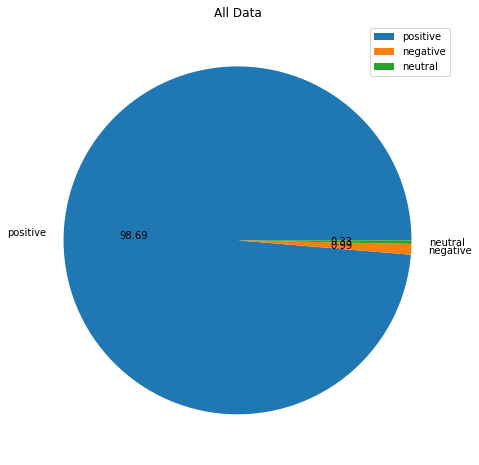

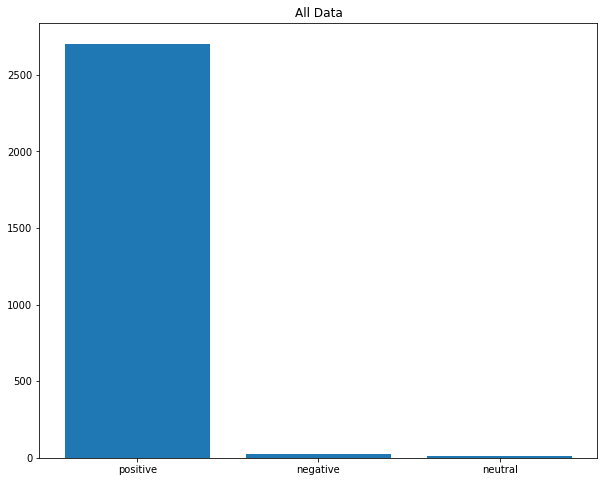

In [104]:
makeChart(data_labelling['sentiment'], 'All Data')
print('\n')
makeBarChart(data_labelling['sentiment'], 'All Data')

## Split data into train and test

In [105]:
testSize = 0.2
randomState = 1

In [106]:
train, test = train_test_split(data_labelling, test_size=testSize, random_state=randomState)
X_train = train['text'].values
X_test = test['text'].values
Y_train = train['sentiment']
Y_test = test['sentiment']

In [107]:
data_train = pd.DataFrame()
data_train['text'] = X_train
data_train['sentiment'] = Y_train

data_test = pd.DataFrame()
data_test['text'] = X_test
data_test['sentiment'] = Y_test

Length, and column

In [108]:
print("\nLength train data:")
print(len(data_train))
print("\Train columns:")
print(data_train.columns)


Length train data:
2190
\Train columns:
Index(['text', 'sentiment'], dtype='object')


In [109]:
print("\nLength test data:")
print(len(data_test))
print("\nTest columns:")
print(data_test.columns)


Length test data:
548

Test columns:
Index(['text', 'sentiment'], dtype='object')


## Chart train and test data

### Train

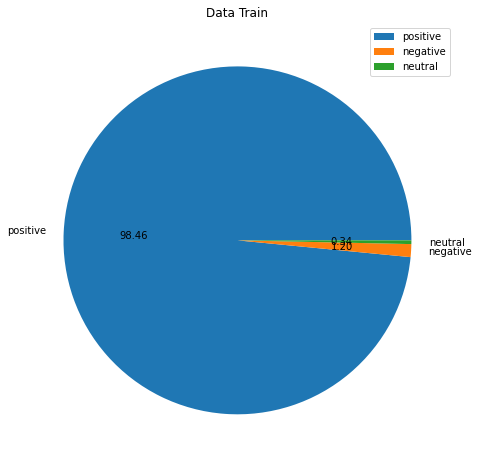

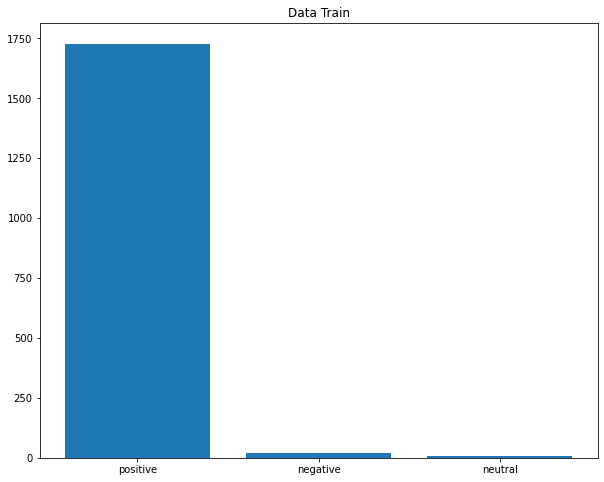

In [110]:
makeChart(data_train['sentiment'], 'Data Train')
print('\n')
makeBarChart(data_train['sentiment'], 'Data Train')

### Test

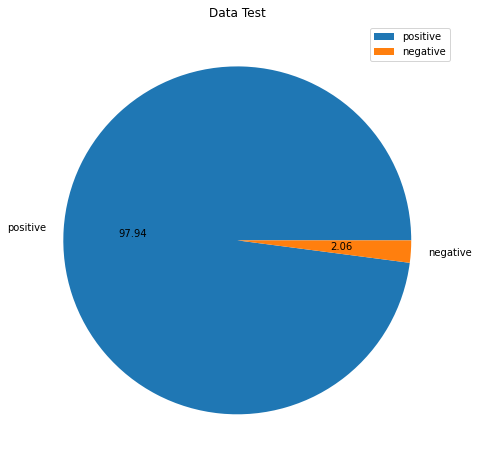

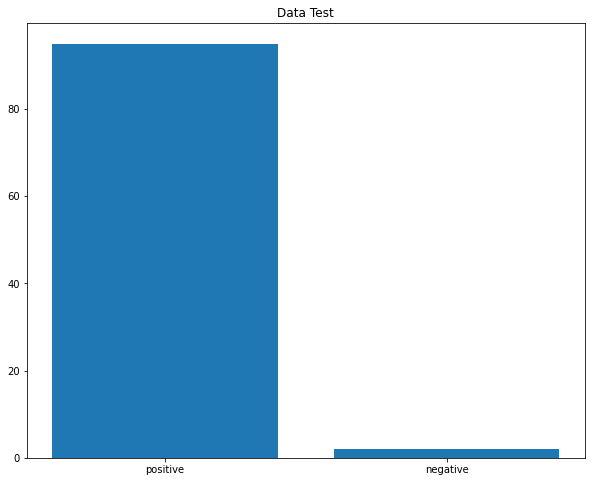

In [111]:
makeChart(data_test['sentiment'], 'Data Test')
print('\n')
makeBarChart(data_test['sentiment'], 'Data Test')

## Checkpoint save train & test data

In [112]:
data_train.to_json(r'/content/data-train.json')
data_test.to_json(r'/content/data-test.json')

## TFIDF

In [113]:
TFIDF = TfidfVectorizer()

In [114]:
TFIDF.fit(data_labelling['text'])
data_train_tfidf = TFIDF.transform(data_train['text'])
data_test_tfidf = TFIDF.transform(data_test['text'])

In [115]:
print(TFIDF.vocabulary_)

{'suka': 4754, 'banget': 465, 'sama': 4303, 'produk': 4035, 'ini': 2191, 'gampang': 1736, 'bawa': 522, 'mana': 2986, 'dan': 1206, 'juga': 2360, 'emang': 1515, 'enak': 1525, 'di': 1285, 'muka': 3231, 'cuma': 1172, 'kurang': 2689, 'agak': 128, 'susah': 4862, 'keluar': 2490, 'gitu': 1840, 'jadi': 2273, 'harus': 1998, 'apply': 337, 'beberapa': 548, 'lama': 2738, 'baru': 508, 'rasa': 4124, 'kalo': 2415, 'isi': 2248, 'aku': 177, 'pertama': 3863, 'kali': 2409, 'beli': 580, 'excited': 1563, 'bgt': 696, 'mau': 3049, 'coba': 1066, 'moga': 3192, 'cocok': 1085, 'hasil': 2002, 'bakal': 434, 'good': 1895, 'hehe': 2024, 'it': 2254, 'really': 4137, 'wajah': 5365, 'jdi': 2310, 'glowing': 1859, 'love': 2893, 'the': 5091, 'packaging': 3688, 'texture': 5074, 'tapi': 4918, 'whitecastnya': 5437, 'yaa': 5500, 'akan': 160, 'sirna': 4595, 'iring': 2242, 'waktu': 5387, 'sih': 4557, 'buat': 861, 'retouch': 4211, 'lumayan': 2919, 'ya': 5499, 'karna': 2446, 'pas': 3788, 'itu': 2262, 'salah': 4294, 'jd': 2308, 'yau

## SVM analysis

### Model

In [116]:
SVMkernel = 'linear'
SVMprobability = True

In [117]:
SVM_model = SVC(kernel=SVMkernel, probability=SVMprobability)
SVM_model.fit(data_train_tfidf, Y_train)

SVC(kernel='linear', probability=True)

### Accuracy

In [118]:
predictions_SVM = SVM_model.predict(data_test_tfidf)
test_prediction = pd.DataFrame()
test_prediction['text'] = X_test
test_prediction['sentiment'] = predictions_SVM
SVM_accuracy = accuracy_score(predictions_SVM, Y_test) * 100
SVM_accuracy = round(SVM_accuracy, 1)

In [119]:
SVM_accuracy

98.5

In [120]:
print("\nSVM classification report:") 
print(classification_report(Y_test, predictions_SVM))


SVM classification report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         5
     neutral       0.00      0.00      0.00         3
    positive       0.99      1.00      0.99       540

    accuracy                           0.99       548
   macro avg       0.33      0.33      0.33       548
weighted avg       0.97      0.99      0.98       548



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Naive bayes analysis

### Model

In [121]:
cnb_model = ComplementNB()
cnb_model.fit(data_train_tfidf, Y_train)

ComplementNB()

In [122]:
bnb_model = BernoulliNB()
bnb_model.fit(data_train_tfidf, Y_train)

BernoulliNB()

In [123]:
mnb_model = MultinomialNB()
mnb_model.fit(data_train_tfidf, Y_train)

MultinomialNB()

### Accuracy

In [124]:
def naiveAccuracy(model, data_test):
  predictions_Naive = model.predict(data_test_tfidf)
  test_prediction = pd.DataFrame()
  test_prediction['text'] = X_test
  test_prediction['sentiment'] = predictions_Naive
  Naive_accuracy = accuracy_score(predictions_Naive, Y_test) * 100
  Naive_accuracy = round(Naive_accuracy, 1)
  
  return predictions_Naive, Naive_accuracy

In [125]:
cnb_acc = naiveAccuracy(cnb_model, data_test_tfidf)
bnb_acc = naiveAccuracy(bnb_model, data_test_tfidf)
mnb_acc = naiveAccuracy(mnb_model, data_test_tfidf)

print(cnb_acc[1])
print(bnb_acc[1])
print(mnb_acc[1])

98.5
98.5
98.5


In [126]:
print("\nNaive bayes ComplementNB classification report:") 
print(classification_report(Y_test, cnb_acc[0]))
print("\nNaive bayes BernoulliNB classification report:") 
print(classification_report(Y_test, bnb_acc[0]))
print("\nNaive bayes MultinomialNB classification report:") 
print(classification_report(Y_test, mnb_acc[0]))


Naive bayes ComplementNB classification report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         5
     neutral       0.50      0.33      0.40         3
    positive       0.99      1.00      0.99       540

    accuracy                           0.99       548
   macro avg       0.50      0.44      0.46       548
weighted avg       0.98      0.99      0.98       548


Naive bayes BernoulliNB classification report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         5
     neutral       0.00      0.00      0.00         3
    positive       0.99      1.00      0.99       540

    accuracy                           0.99       548
   macro avg       0.33      0.33      0.33       548
weighted avg       0.97      0.99      0.98       548


Naive bayes MultinomialNB classification report:
              precision    recall  f1-score   support

    negative       0.00      0.00   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

## Conclusion

In [141]:
def top_words(data, title):
  words_list = data.split(' ')
  counts = Counter(words_list)
  top_words = counts.most_common(30)
  length_of_list = len(top_words)
  index = np.arange(length_of_list)
  print(top_words)
  count_values = [x[1] for x in top_words]
  count_words = [x[0] for x in top_words]
  fig = plt.figure(figsize = (16,9))
  bar_width = 0.4
  rects1 = plt.bar(index, count_values)
  plt.xticks(index + bar_width, count_words, rotation=0)
  plt.title(title)
  plt.savefig("%s-.png"%title)
  plt.show()

In [142]:
def makeWordcloud(data, title):
  wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(data)
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.title(title)
  plt.savefig("%s-.png"%title)
  plt.show()

### Sociolla

In [143]:
sociolla_positive_sentiment = data_labelling[(data_labelling['sentiment'] == 'positive') & (data_labelling['source'] == 'sociolla')]
sociolla_positive_words = ' '.join(sociolla_positive_sentiment['text'])

[('dan', 2857), ('banget', 2799), ('ini', 2666), ('aku', 2363), ('sunscreen', 2270), ('kulit', 1672), ('di', 1618), ('yang', 1427), ('juga', 1297), ('ga', 1292), ('jadi', 1167), ('buat', 1074), ('suka', 1056), ('bikin', 1034), ('sama', 994), ('nya', 973), ('npure', 971), ('wajah', 959), ('produk', 906), ('yg', 844), ('bagus', 794), ('tekstur', 763), ('pake', 735), ('dari', 719), ('ringan', 719), ('powder', 696), ('gak', 695), ('pakai', 695), ('bgt', 660), ('cocok', 625)]


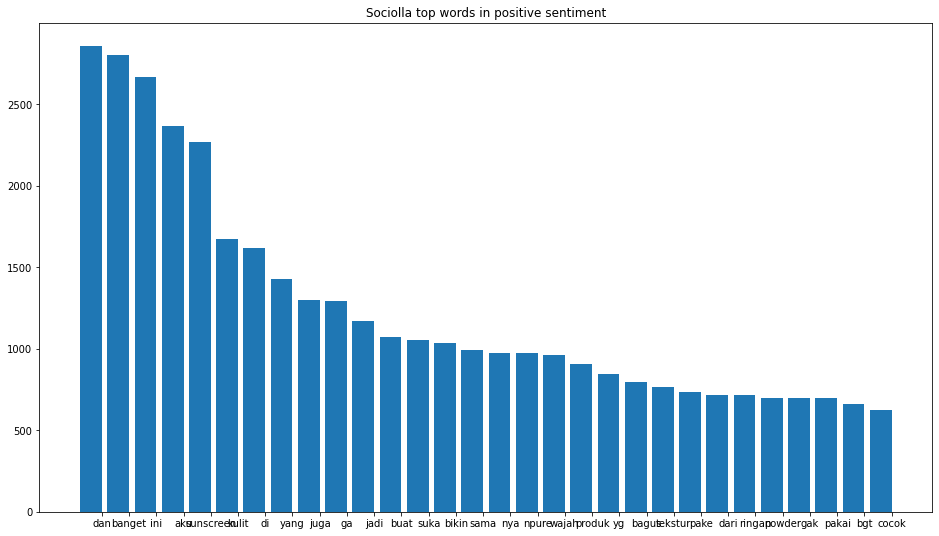

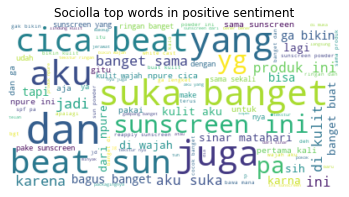

In [144]:
top_words(sociolla_positive_words, "Sociolla top words in positive sentiment")
print("\n")
makeWordcloud(sociolla_positive_words, "Sociolla top words in positive sentiment")

In [145]:
sociolla_negative_sentiment = data_labelling[(data_labelling['sentiment'] == 'negative') & (data_labelling['source'] == 'sociolla')]
sociolla_negative_words = ' '.join(sociolla_negative_sentiment['text'])

[('bagus', 160), ('ini', 35), ('ga', 27), ('di', 27), ('banget', 19), ('aku', 19), ('yg', 19), ('sunscreen', 17), ('tp', 17), ('produk', 16), ('tapi', 15), ('pake', 15), ('ya', 14), ('bedak', 13), ('jd', 13), ('jadi', 13), ('kulit', 12), ('karena', 11), ('dan', 11), ('wajah', 11), ('kalo', 11), ('bgt', 10), ('apa', 10), ('sih', 9), ('untuk', 9), ('sama', 9), ('gak', 8), ('bingung', 8), ('buat', 8), ('aja', 8)]


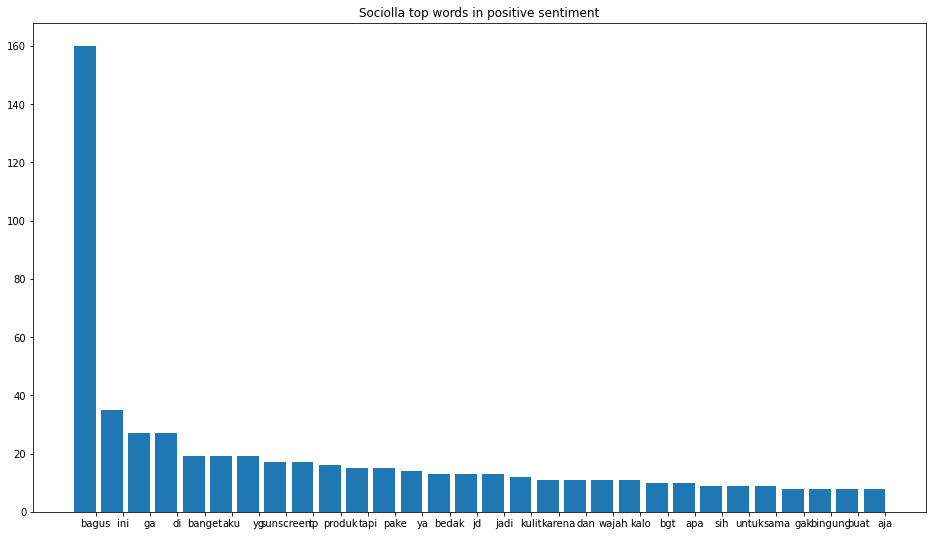

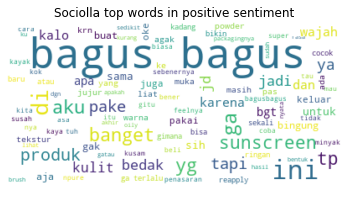

In [146]:
top_words(sociolla_negative_words, "Sociolla top words in positive sentiment")
print("\n")
makeWordcloud(sociolla_negative_words, "Sociolla top words in positive sentiment")

### Female daily

In [147]:
femaleDaily_positive_sentiment = data_labelling[(data_labelling['sentiment'] == 'positive') & (data_labelling['source'] == 'femaleDaily')]
femaleDaily_positive_words = ' '.join(femaleDaily_positive_sentiment['text'])

[('ini', 204), ('banget', 198), ('dan', 178), ('aku', 172), ('sunscreen', 138), ('di', 132), ('kulit', 126), ('buat', 100), ('ga', 100), ('juga', 98), ('yang', 94), ('powder', 78), ('produk', 72), ('jadi', 72), ('suka', 72), ('sama', 70), ('pake', 62), ('bikin', 58), ('wajah', 56), ('cocok', 54), ('lagi', 52), ('bagus', 52), ('tekstur', 52), ('makeup', 50), ('bisa', 48), ('dari', 48), ('npure', 48), ('yg', 48), ('sun', 46), ('bgt', 46)]


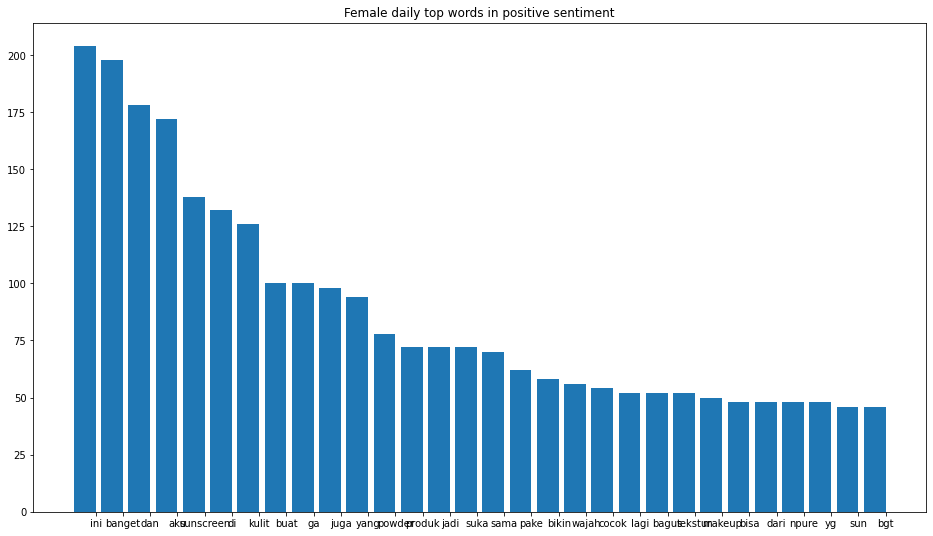

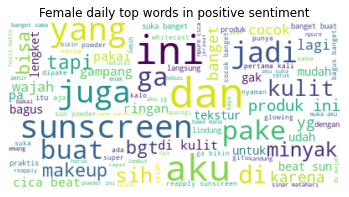

In [148]:
top_words(femaleDaily_positive_words, "Female daily top words in positive sentiment")
print("\n")
makeWordcloud(femaleDaily_positive_words, "Female daily top words in positive sentiment")

### Accuracy

In [149]:
print("\nSVM bayes classification report:") 
print(classification_report(Y_test, predictions_SVM))


SVM bayes classification report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         5
     neutral       0.00      0.00      0.00         3
    positive       0.99      1.00      0.99       540

    accuracy                           0.99       548
   macro avg       0.33      0.33      0.33       548
weighted avg       0.97      0.99      0.98       548



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [150]:
print("\nNaive bayes ComplementNB classification report:") 
print(classification_report(Y_test, cnb_acc[0]))
print("\nNaive bayes BernoulliNB classification report:") 
print(classification_report(Y_test, bnb_acc[0]))
print("\nNaive bayes MultinomialNB classification report:") 
print(classification_report(Y_test, mnb_acc[0]))


Naive bayes ComplementNB classification report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         5
     neutral       0.50      0.33      0.40         3
    positive       0.99      1.00      0.99       540

    accuracy                           0.99       548
   macro avg       0.50      0.44      0.46       548
weighted avg       0.98      0.99      0.98       548


Naive bayes BernoulliNB classification report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         5
     neutral       0.00      0.00      0.00         3
    positive       0.99      1.00      0.99       540

    accuracy                           0.99       548
   macro avg       0.33      0.33      0.33       548
weighted avg       0.97      0.99      0.98       548


Naive bayes MultinomialNB classification report:
              precision    recall  f1-score   support

    negative       0.00      0.00   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

### Note

From this data

In [151]:
print("Length data labelling:", len(data_labelling))
print("Split data test size:", testSize)
print("Split data random state:", randomState)
print("Length train data:", len(data_train))
print("Length test data:", len(data_test))
print("Length train data positive:", len(data_train[data_train['sentiment'] == 'positive']))
print("Length train data negative:", len(data_train[data_train['sentiment'] == 'negative']))
print("Length test data positive:", len(data_test[data_test['sentiment'] == 'positive']))
print("Length test data negative:", len(data_test[data_test['sentiment'] == 'negative']))
print("SVM kernel:", SVMkernel)
print("SVM probability:", SVMprobability)

Length data labelling: 2738
Split data test size: 0.2
Split data random state: 1
Length train data: 2190
Length test data: 548
Length train data positive: 1728
Length train data negative: 21
Length test data positive: 95
Length test data negative: 2
SVM kernel: linear
SVM probability: True


got this accuracy

In [152]:
print("SVM accuracy:", SVM_accuracy)
print("Naive Bayes ComplementNB accuracy:", cnb_acc[1])
print("Naive Bayes BernoulliNB accuracy:", bnb_acc[1])
print("Naive Bayes MultinomialNB accuracy:", mnb_acc[1])

SVM accuracy: 98.5
Naive Bayes ComplementNB accuracy: 98.5
Naive Bayes BernoulliNB accuracy: 98.5
Naive Bayes MultinomialNB accuracy: 98.5
